In [83]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [84]:
import seaborn as sns
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [85]:
import quandl as q
token="Us3wFmXGgAj_1cUtHAAR"

In [86]:


sp=q.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken=token).Value

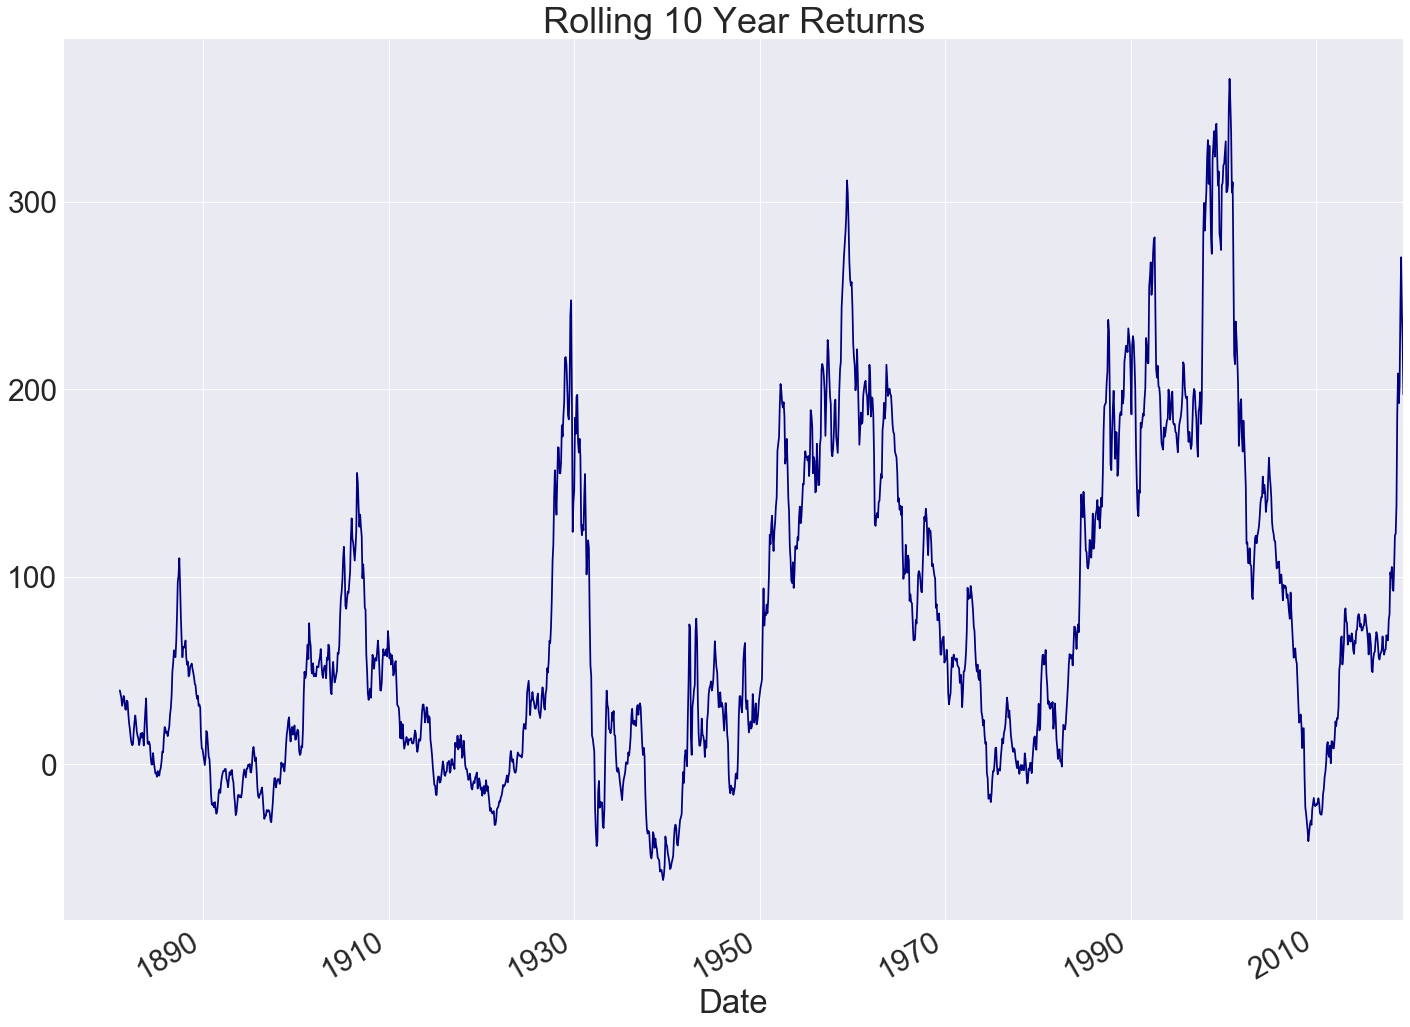

In [125]:
(sp.pct_change(120)*100)['1875':].plot(colormap='jet',title='Rolling 10 Year Returns')

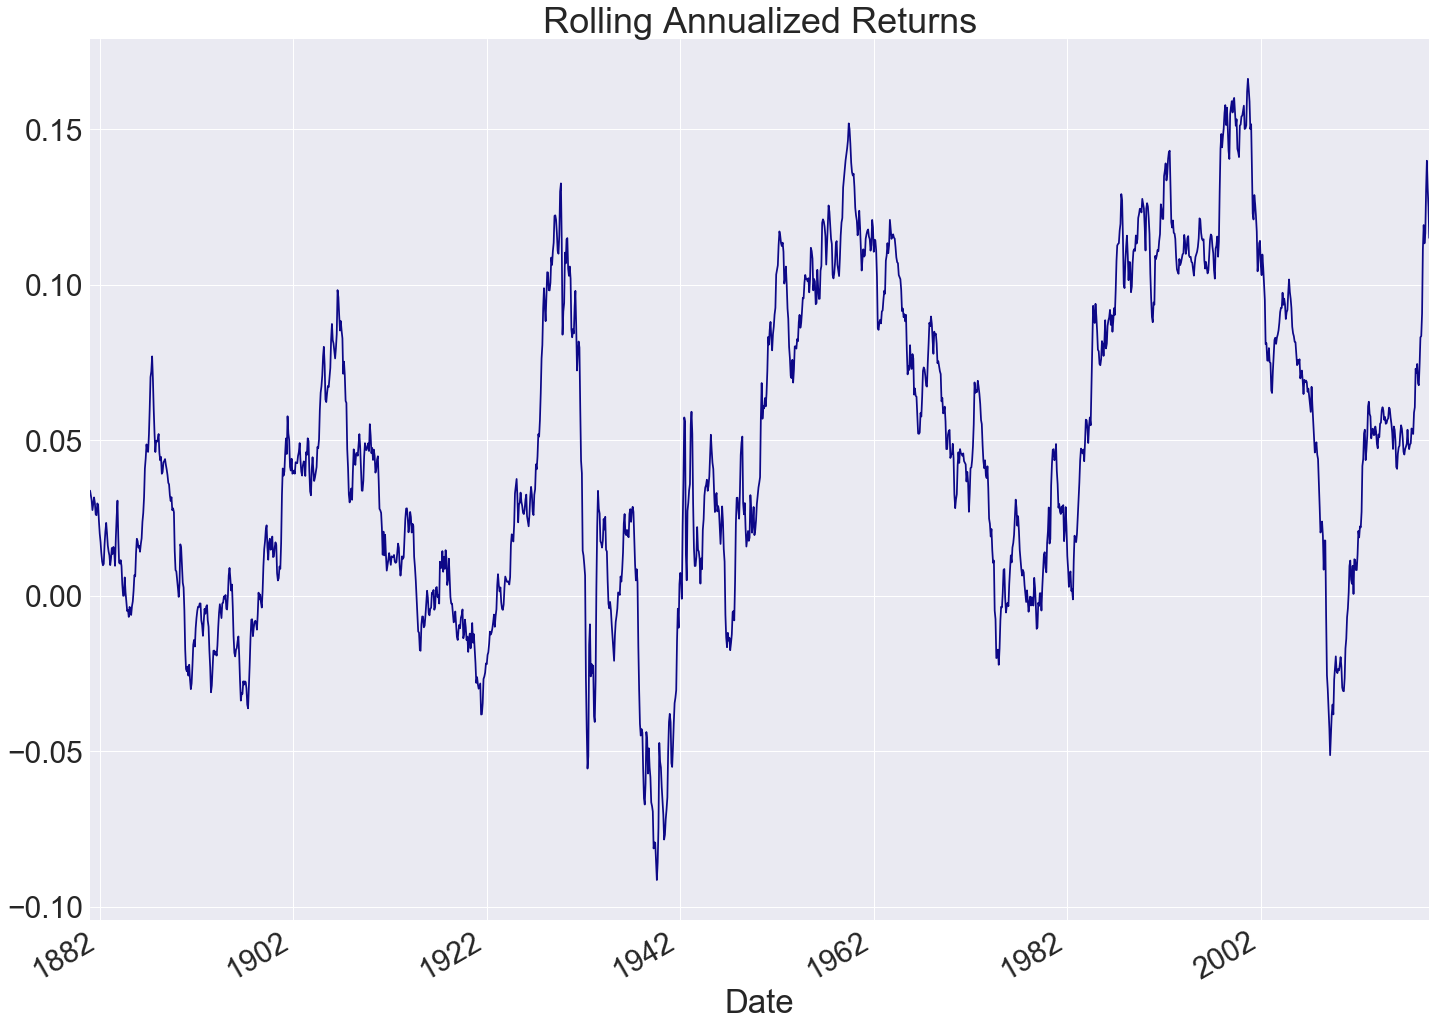

In [163]:
rolling_ann_rtns=((((sp.pct_change(120))['1875':]+1)**.1)-1).dropna()
rolling_ann_rtns.plot(title='Rolling Annualized Returns',colormap='plasma')10y 

In [169]:
# Total under water
rolling_ann_rtns[rolling_ann_rtns<0].count()/rolling_ann_rtns.count()

0.19855595667870035

In [170]:
# Total under 5%
rolling_ann_rtns[rolling_ann_rtns<0.05].count()/rolling_ann_rtns.count()

0.57761732851985559

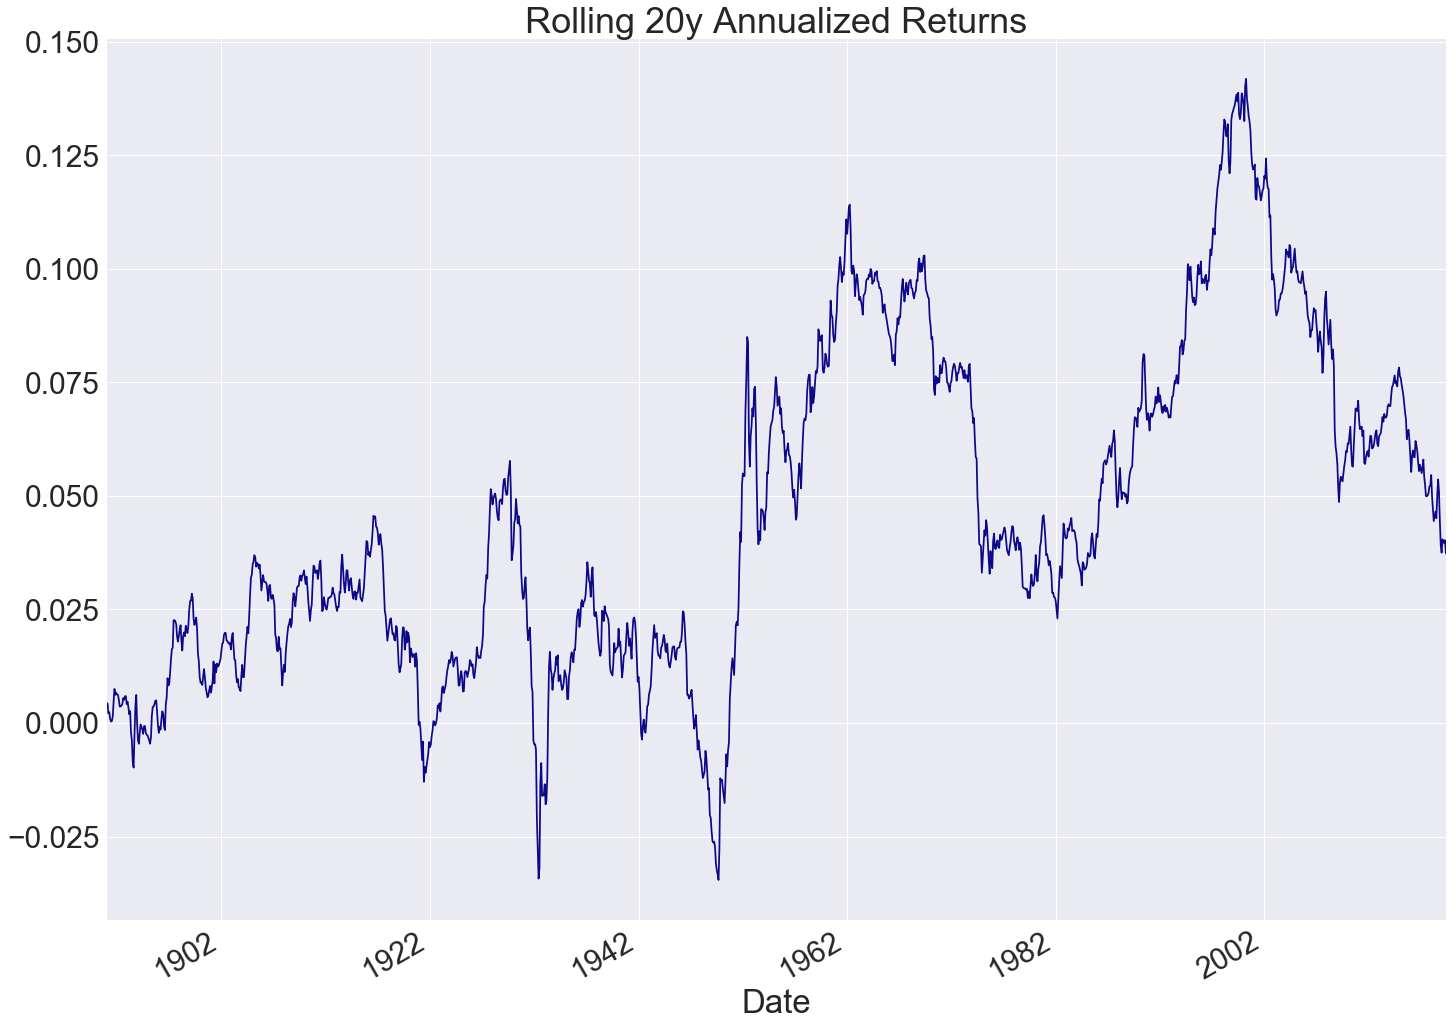

In [172]:
rolling_ann_rtns20=((((sp.pct_change(240))['1875':]+1)**.05)-1).dropna()
rolling_ann_rtns20.plot(title='Rolling 20y Annualized Returns',colormap='plasma')

In [6]:
roll=(sp.pct_change(120)*100).dropna()

In [139]:
((sp.pct_change()+1)['1999':'2008'].cumprod()*100).to_clipboard()

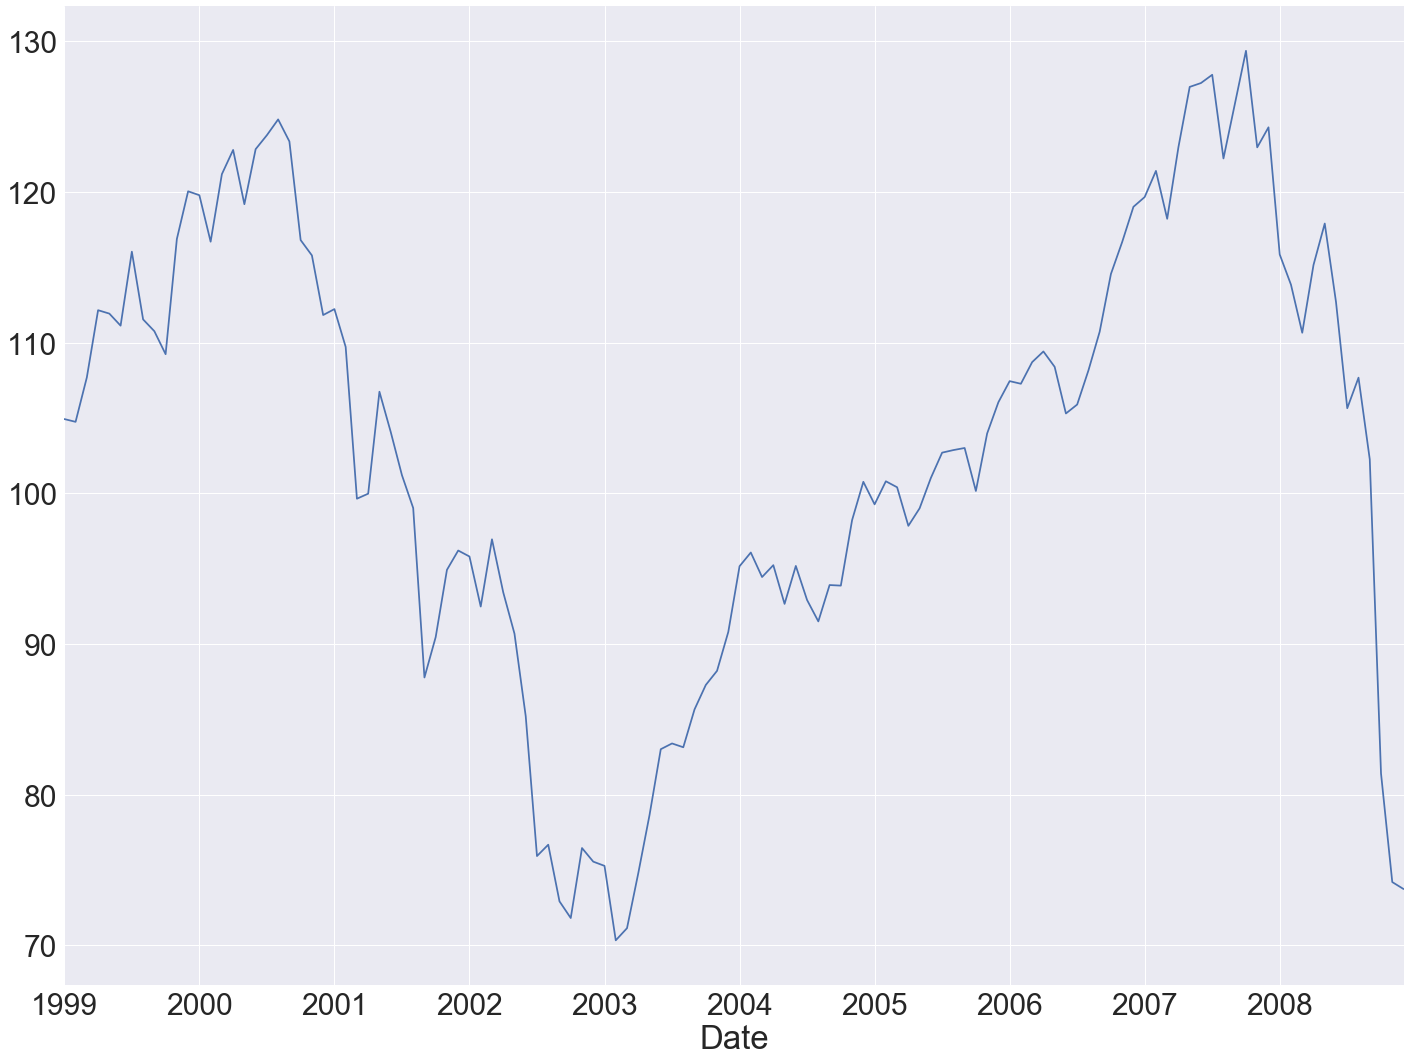

In [140]:
((sp.pct_change()+1)['1999':'2008'].cumprod()*100).plot()

In [143]:
(sp.pct_change()+1)['1999':'2008'].cumprod().iloc[-1]**.1-1

-0.030001280215987247

In [97]:
((sp.pct_change(120).dropna()+1)**.1-1).to_csv('10y_annual.csv')

In [98]:
pwd

'/Users/mrefermat/git/quant_finance'

In [99]:
((sp.pct_change(120).dropna()+1)**.1-1).to_clipboard()

In [100]:
((sp.pct_change(120).dropna()+1)**.1-1).head()

Date
1881-01-01    0.033786
1881-02-01    0.032066
1881-03-01    0.030738
1881-04-01    0.027546
1881-05-01    0.029503
Name: Value, dtype: float64

In [7]:
roll[roll<0].count()/roll.count()

0.19867549668874171

In [8]:
roll2=roll['1919':]
roll2[roll2<0].count()/roll2.count()

0.16680497925311202

In [9]:
roll[roll<0].min()

-61.661129568106318

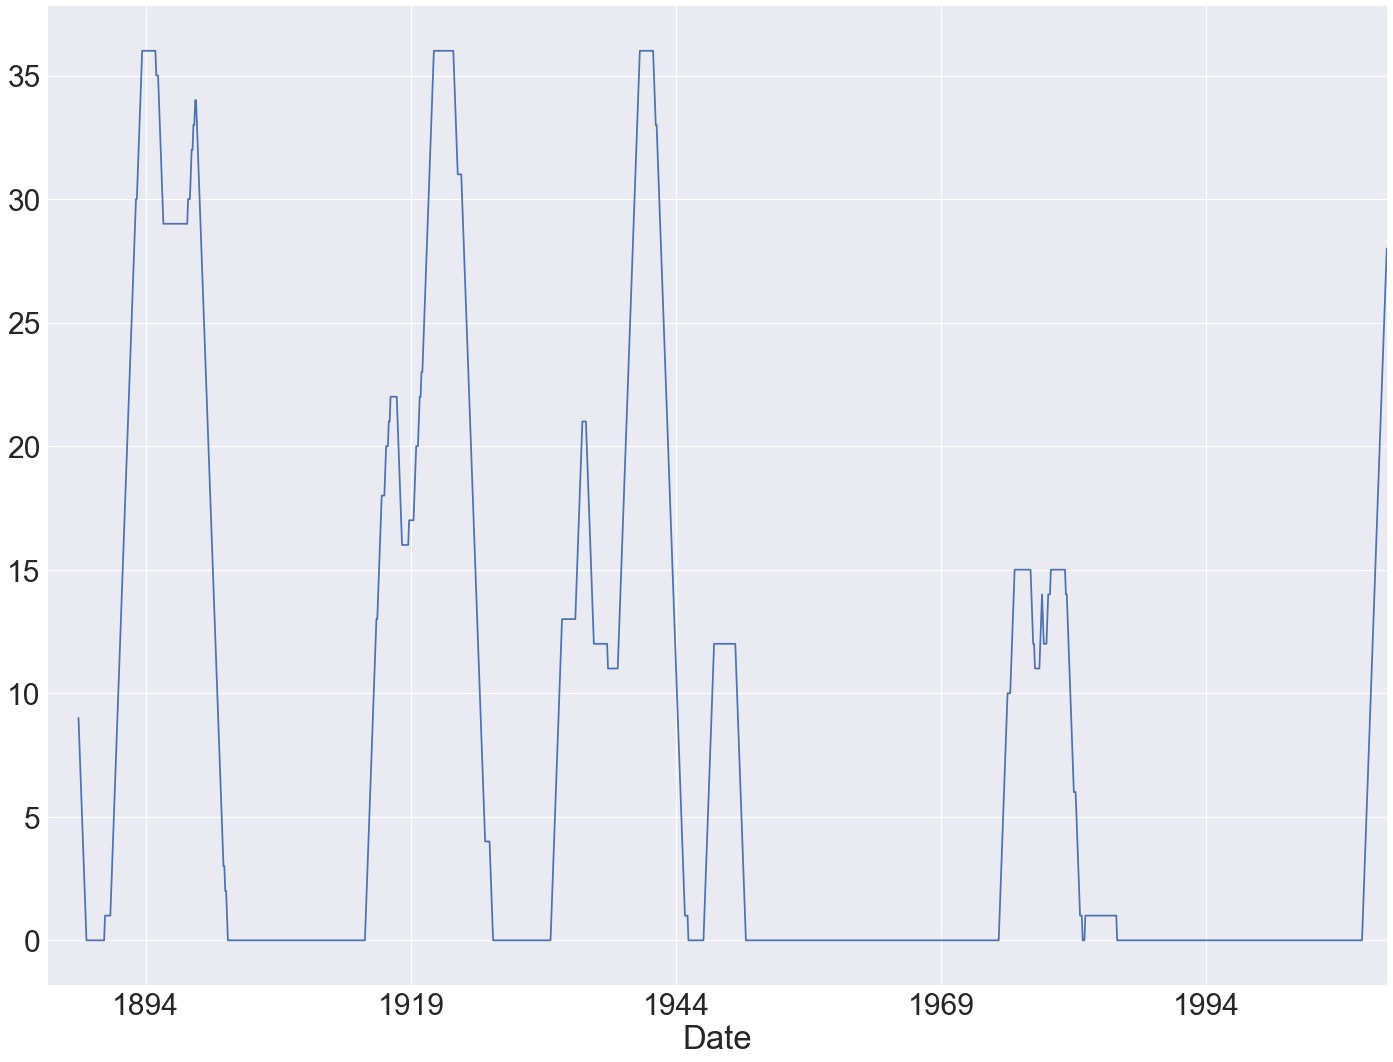

In [10]:
c=roll[roll<0].resample(rule='m').count()
c.rolling(36).sum().plot()

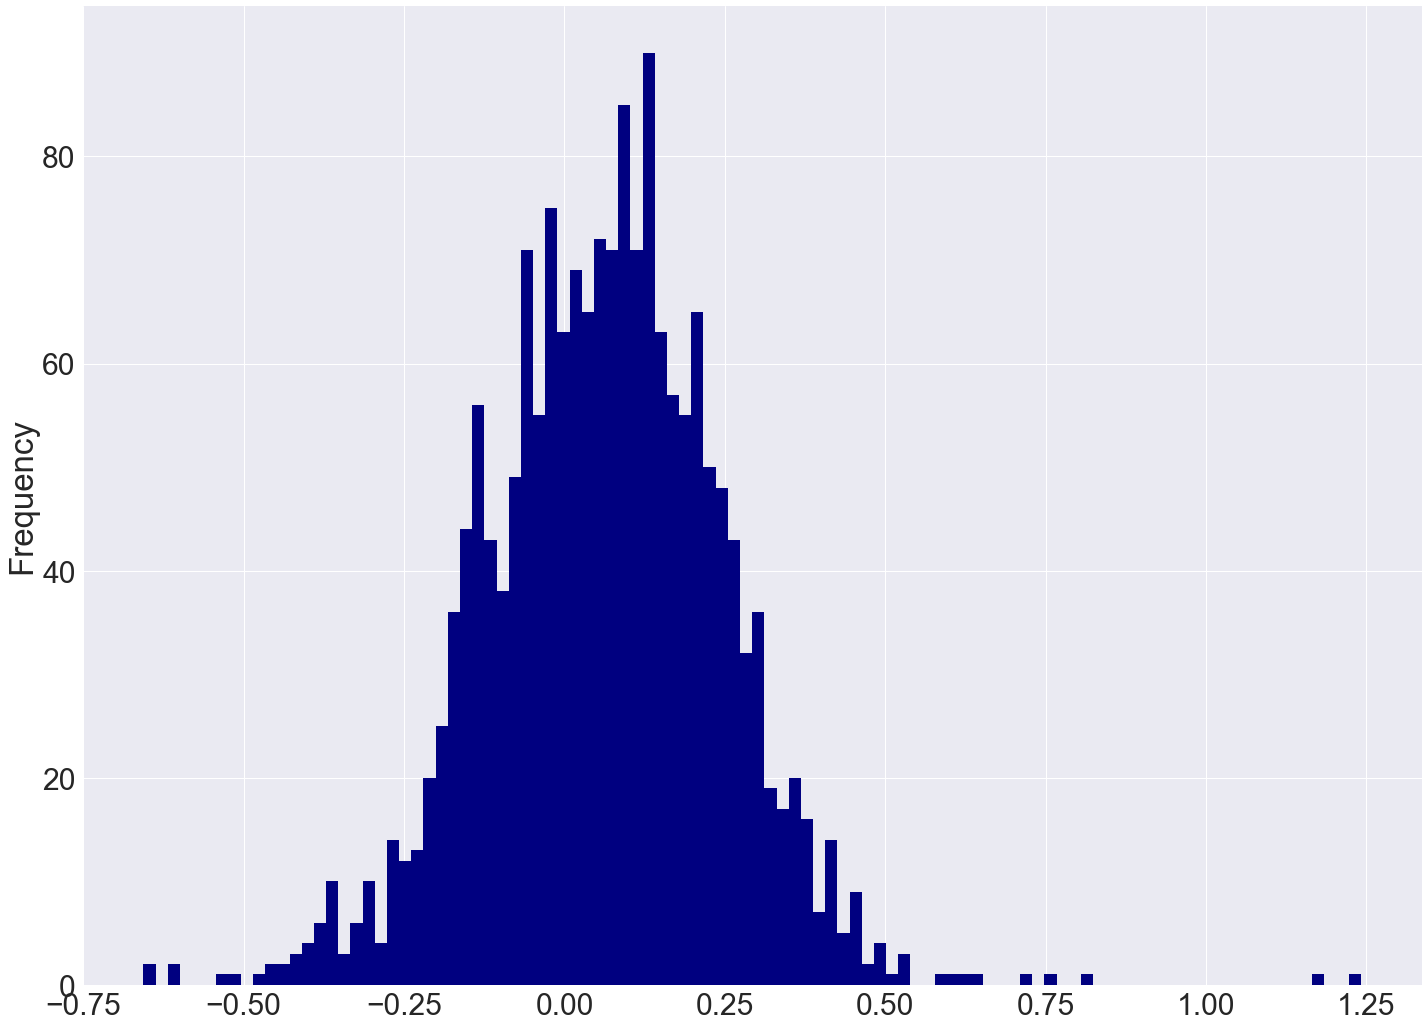

In [20]:
sp.pct_change(12).plot(kind='hist',bins=100,colormap='jet')

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1000000,min_periods=1,center=False).max()
  


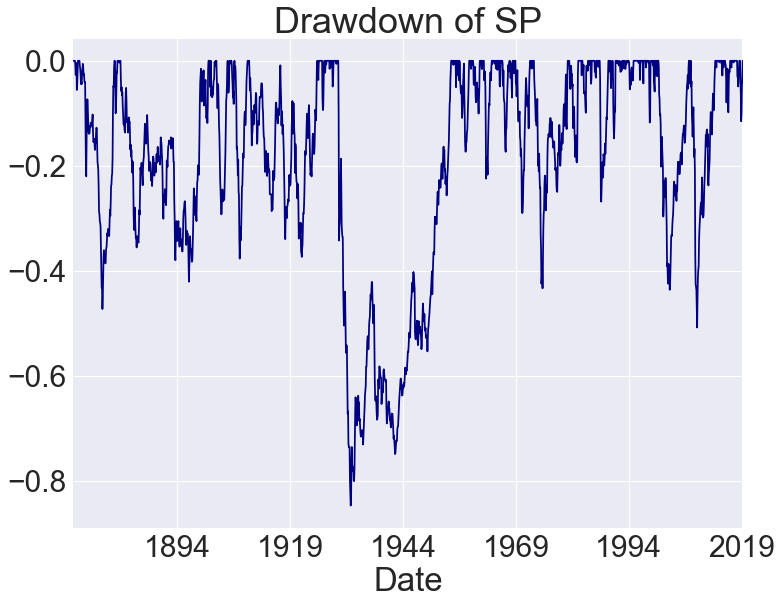

In [78]:
pylab.rcParams['figure.figsize'] = (12, 9)
(sp/pd.rolling_max(sp,1000000,min_periods=1)-1).plot(colormap='jet',title='Drawdown of SP')

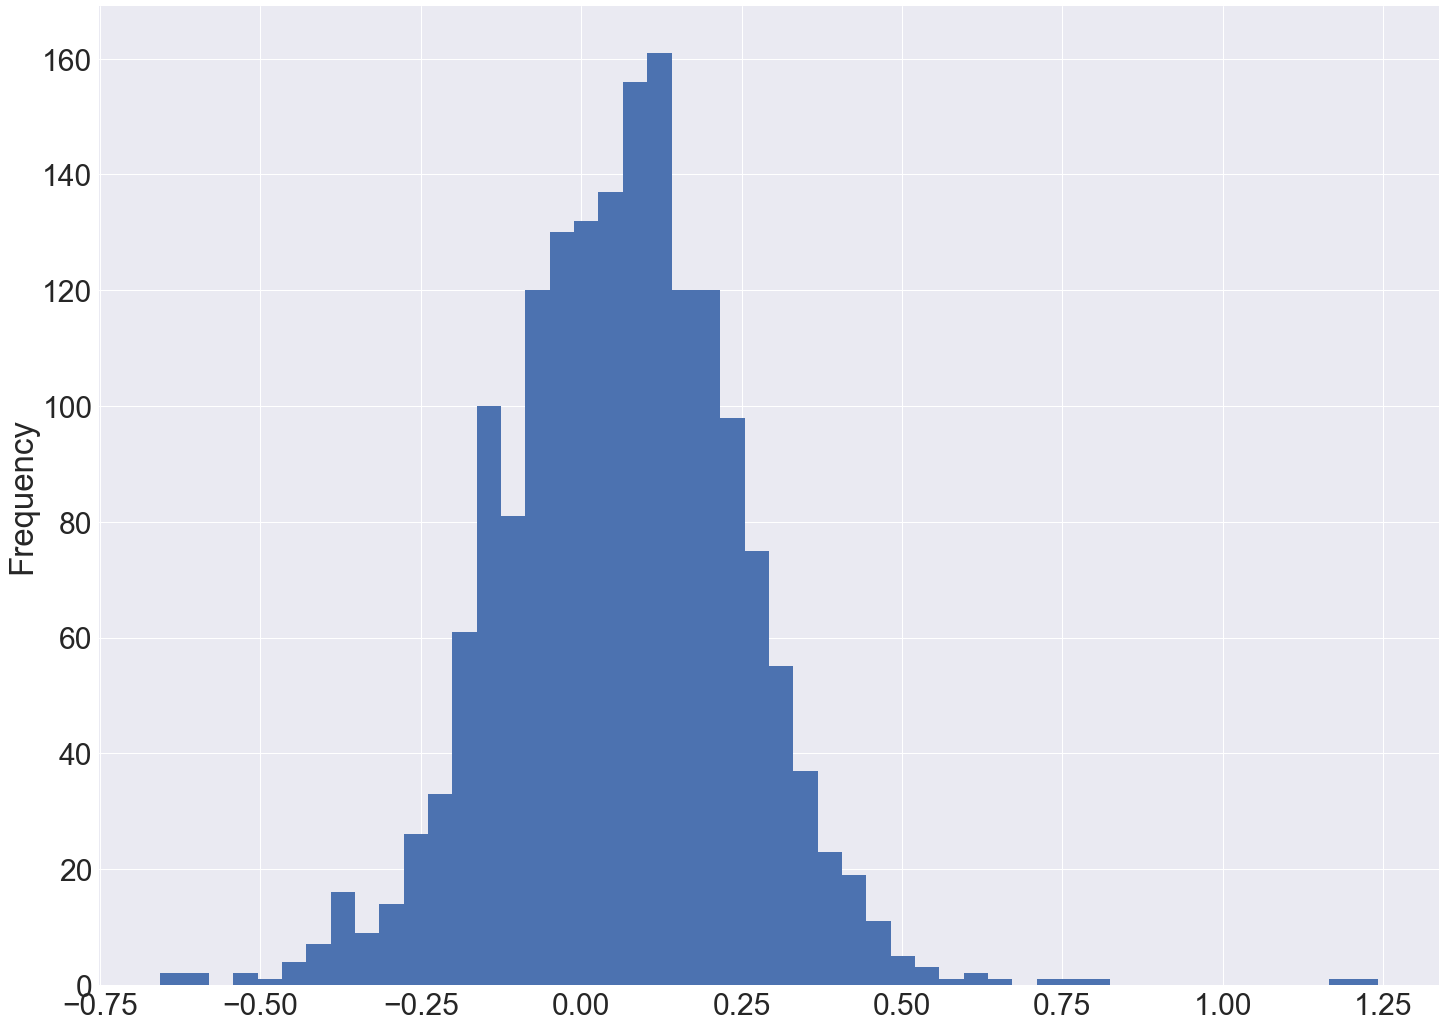

In [21]:
sp.pct_change(12).plot(kind='hist',bins=50)

In [22]:
yld=q.get("FRED/DGS10", authtoken=token).Value

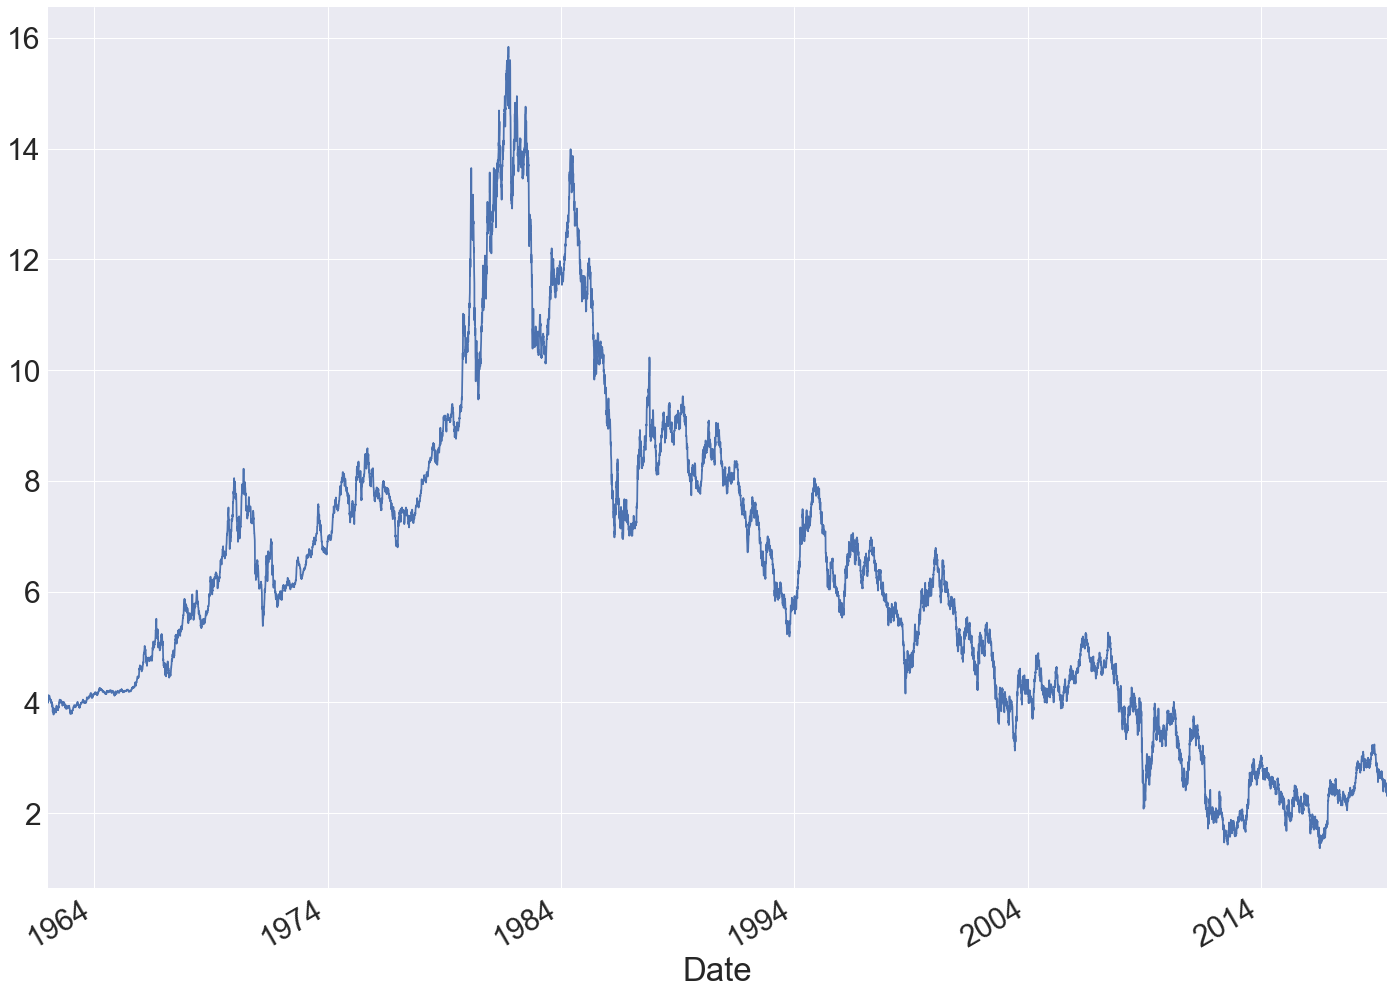

In [23]:
yld.plot()

In [24]:
def yields_to_rtn_index(yld):
    s = pd.Series()
    last=4.06
    for timestamp,yi in yld.iteritems():
        interest = yi/1200.
        np.pv(0.0403,10,4.06,fv=100)
        change=np.pv(yi/100.,10,-last,fv=-100)-100
        last=yi
        s[timestamp]=change+interest
    return s

In [25]:
bd_rtn=yields_to_rtn_index(yld.resample(rule='m').last())

In [26]:
df = pd.DataFrame()
df['SP']=sp.resample(rule='m').last().pct_change()
df['Bonds']=bd_rtn.resample(rule='m').last()/100
df=df.dropna()

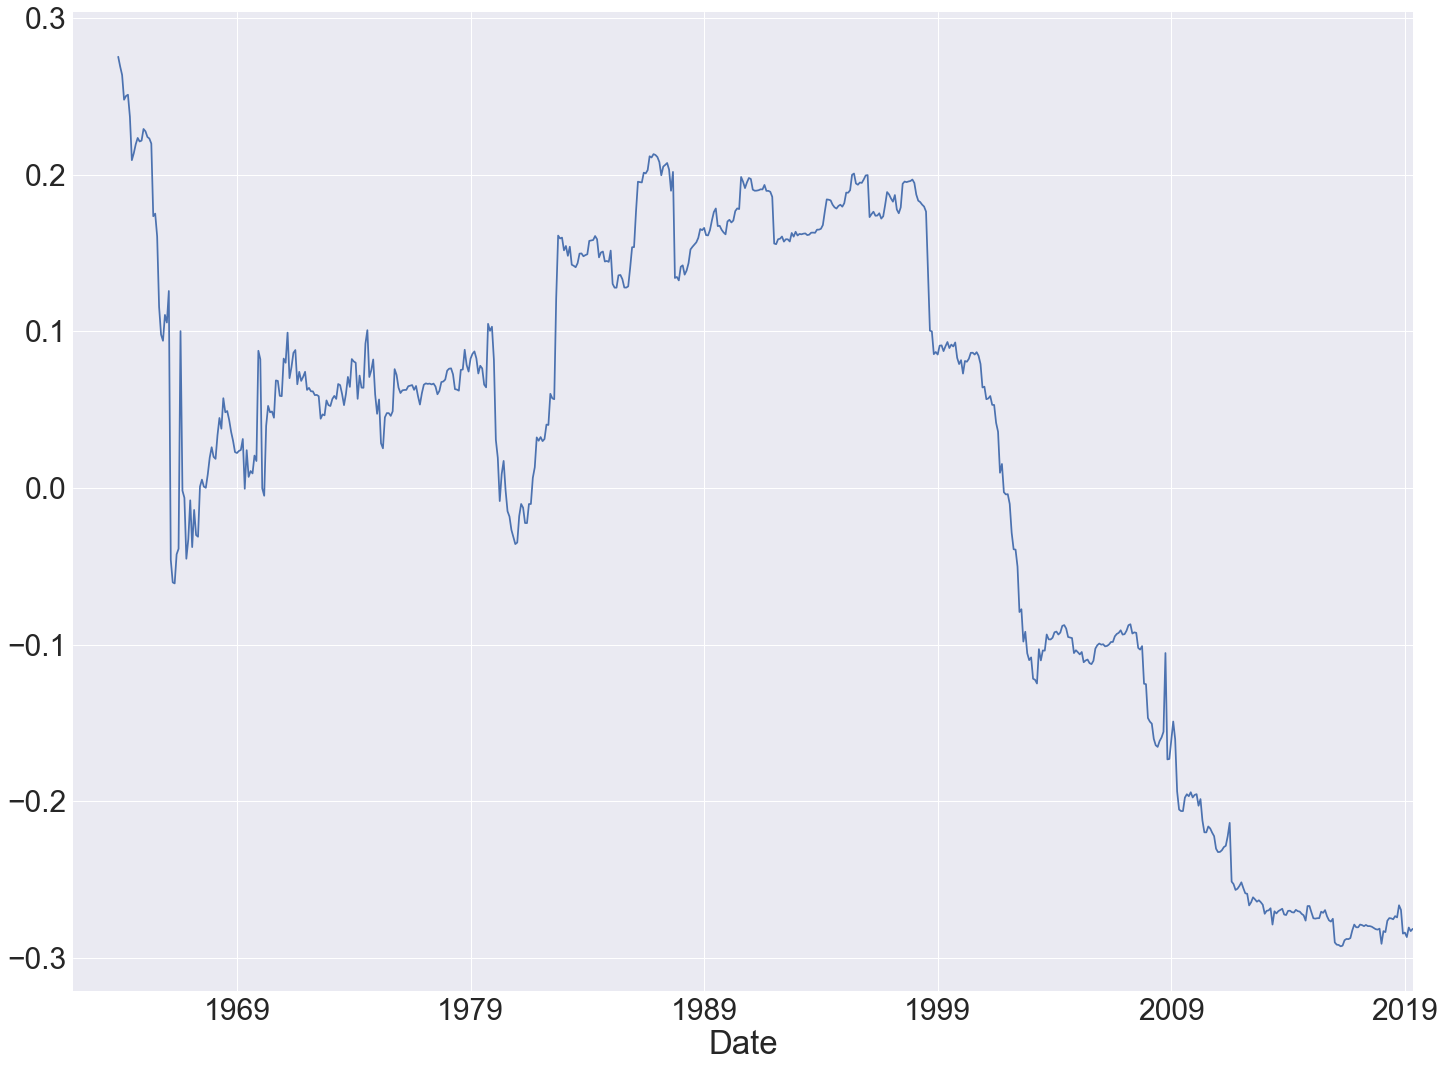

In [27]:
df.SP.ewm(120,min_periods=24).corr(df.Bonds).plot()

In [28]:
inf=q.get("RATEINF/INFLATION_USA", authtoken=token).Value

In [79]:
df2=pd.DataFrame()
df2['Stock Bond Correlation']=df.SP.rolling(120,min_periods=48).corr(df.Bonds)
#df2['US Inflation Rolling 3 Year']=pd.Series.rolling(inf,36).mean()

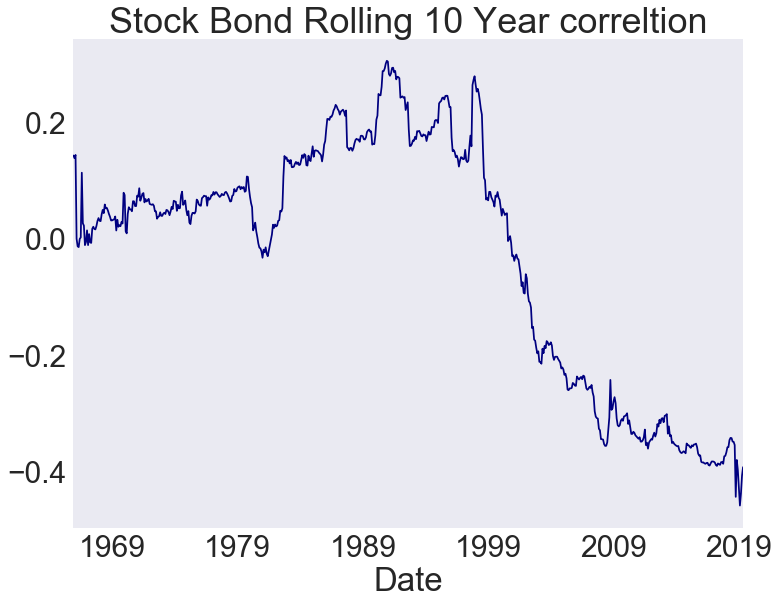

In [82]:
df2.dropna().plot(secondary_y='US Inflation Rolling 3 Year',colormap='jet',title='Stock Bond Rolling 10 Year correltion',legend=False)

In [52]:
w=pd.Series({'SP':0.6,'Bonds':.4})
portfolios= df.multiply(w).sum(axis=1)

In [72]:
sb_corr=df.SP.rolling(60,min_periods=24).corr(df.Bonds)

In [73]:
above = sb_corr[sb_corr>sb_corr.median()].index
below = sb_corr[sb_corr<sb_corr.median()].index

In [74]:
res=pd.Series()
res['Low']=portfolios[below].std()*math.sqrt(12)
res['High']=portfolios[above].std()*math.sqrt(12)

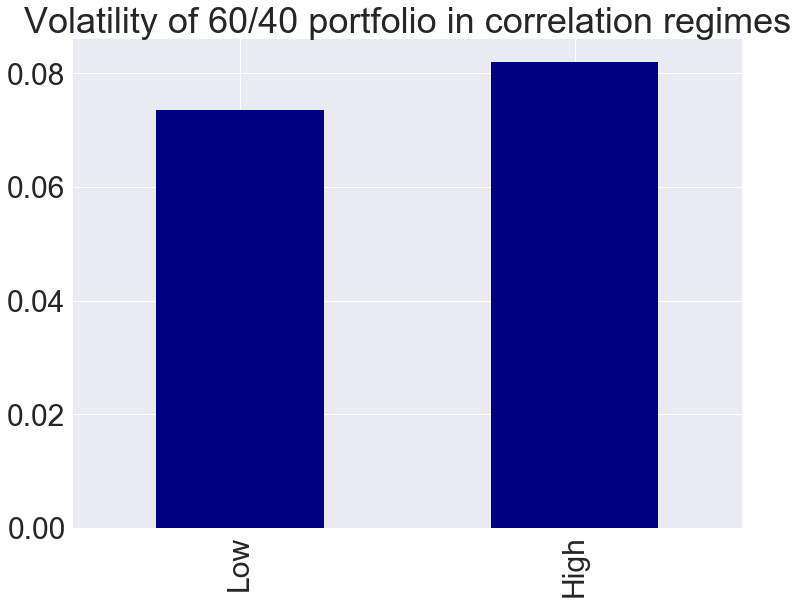

In [77]:
pylab.rcParams['figure.figsize'] = (12, 9)
res.plot(kind='bar',colormap='jet',title='Volatility of 60/40 portfolio in correlation regimes')
pylab.rcParams['figure.figsize'] = (24, 18)

#  Quick findings

*  Increased correlation means of course increased volatility in portfolios
*  

In [42]:
sf=portfolios.std()/1.4492


In [48]:
portfolios=pd.DataFrame()
portfolios['RP']=((df/pd.rolling_std(df,24)).dropna().sum(axis=1)*sf)
#portfolios['60/40']=df.multiply(w).sum(axis=1)

/Users/mrefermat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()
  


In [44]:
def calc_Sharpe(pnl,N=12):
    return np.sqrt(N) * pnl.mean() / pnl.std()

In [45]:
df.cumsum().tail()

,SP,Bonds
Date,,
2019-01-31,4.033851,0.265213
2019-02-28,4.090409,0.256587
2019-03-31,4.108240,0.284744
2019-04-30,4.143839,0.276017
2019-05-31,4.153712,0.293714


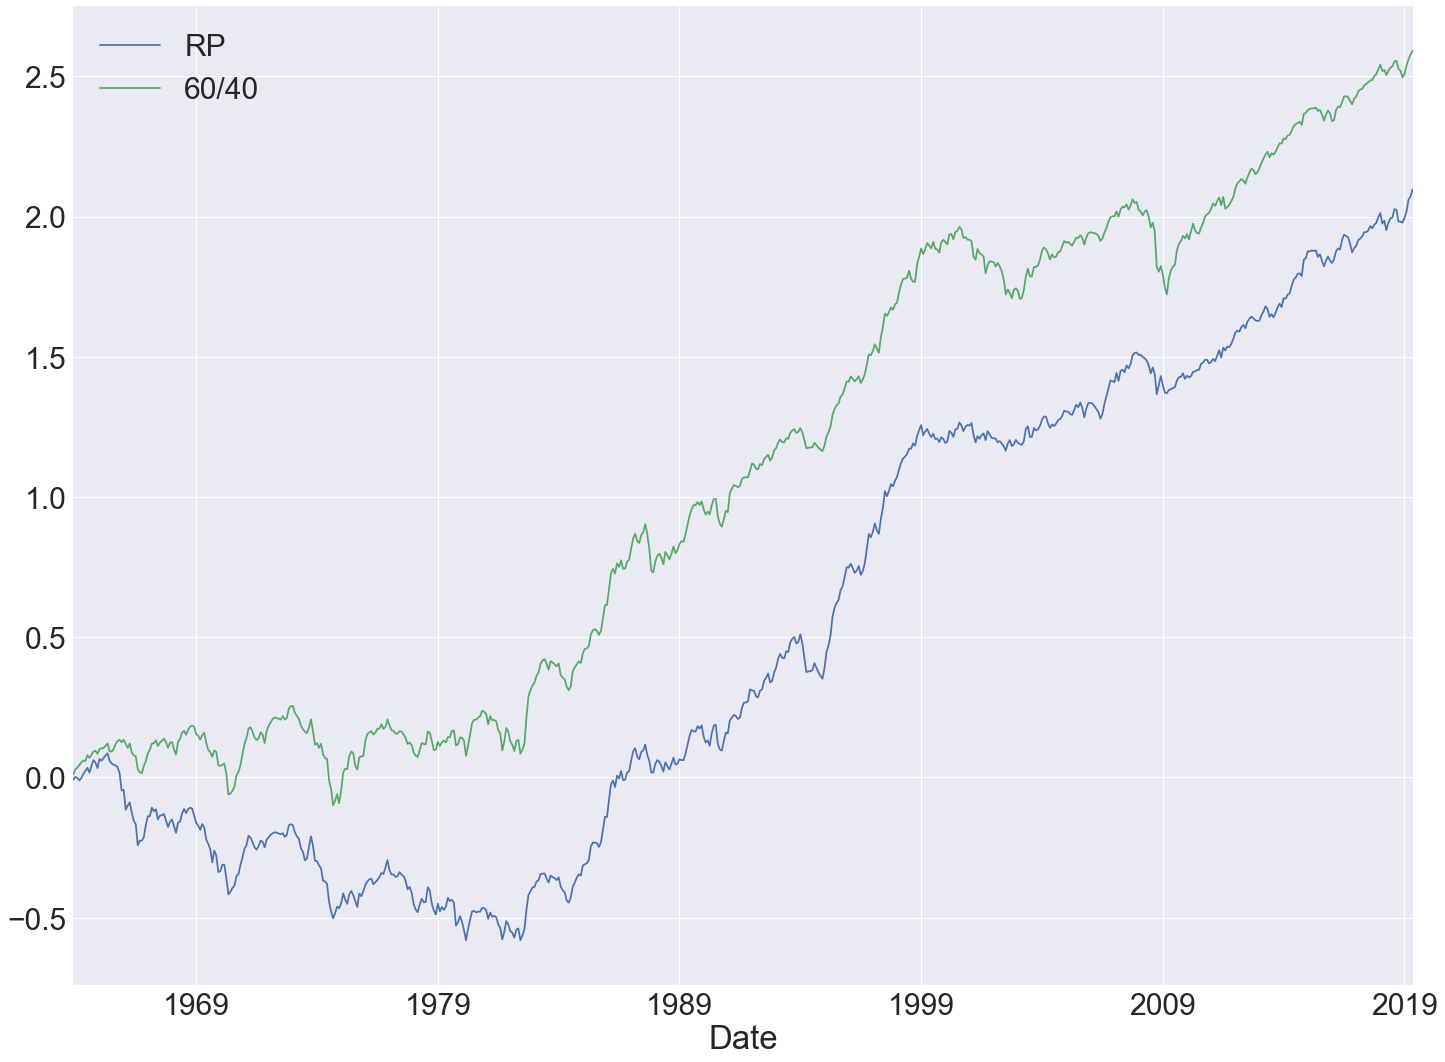

In [46]:
portfolios.cumsum().plot()

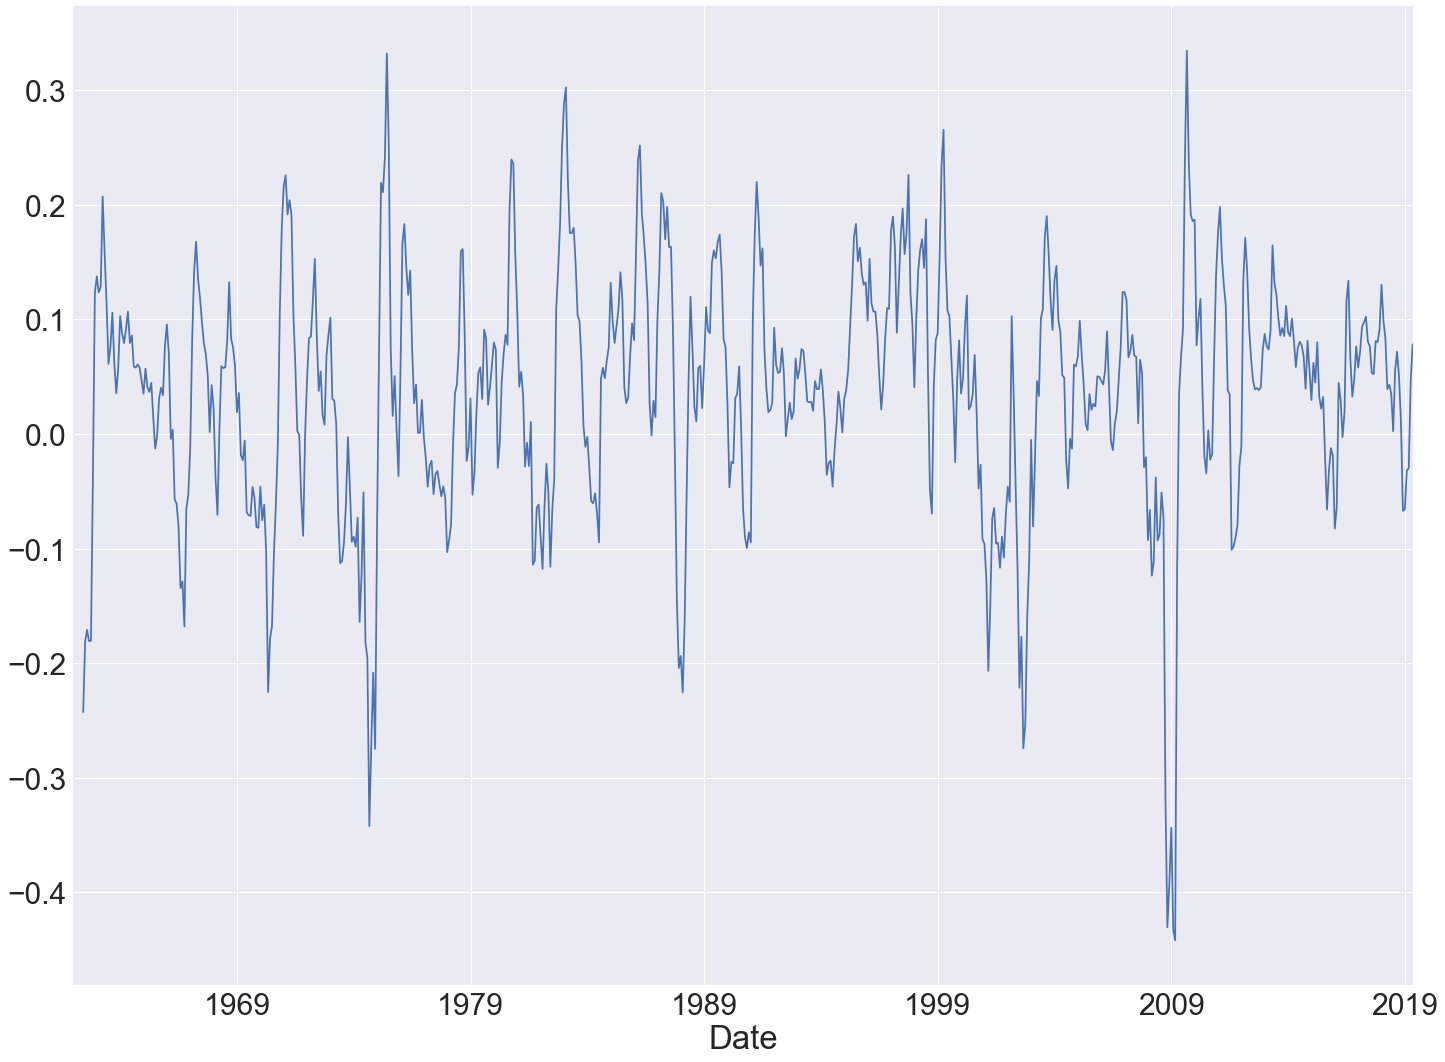

In [152]:
pd.Series.rolling(df.SP,6).sum().plot()

# U / V shape recovery versus flat returns

In [57]:
a=[[0.00,0],
    [0.01,-0.30],
  [0.01,0.10],
   [0.01,0.10],
   [0.01,0.10],
  [0.01,0.10],]

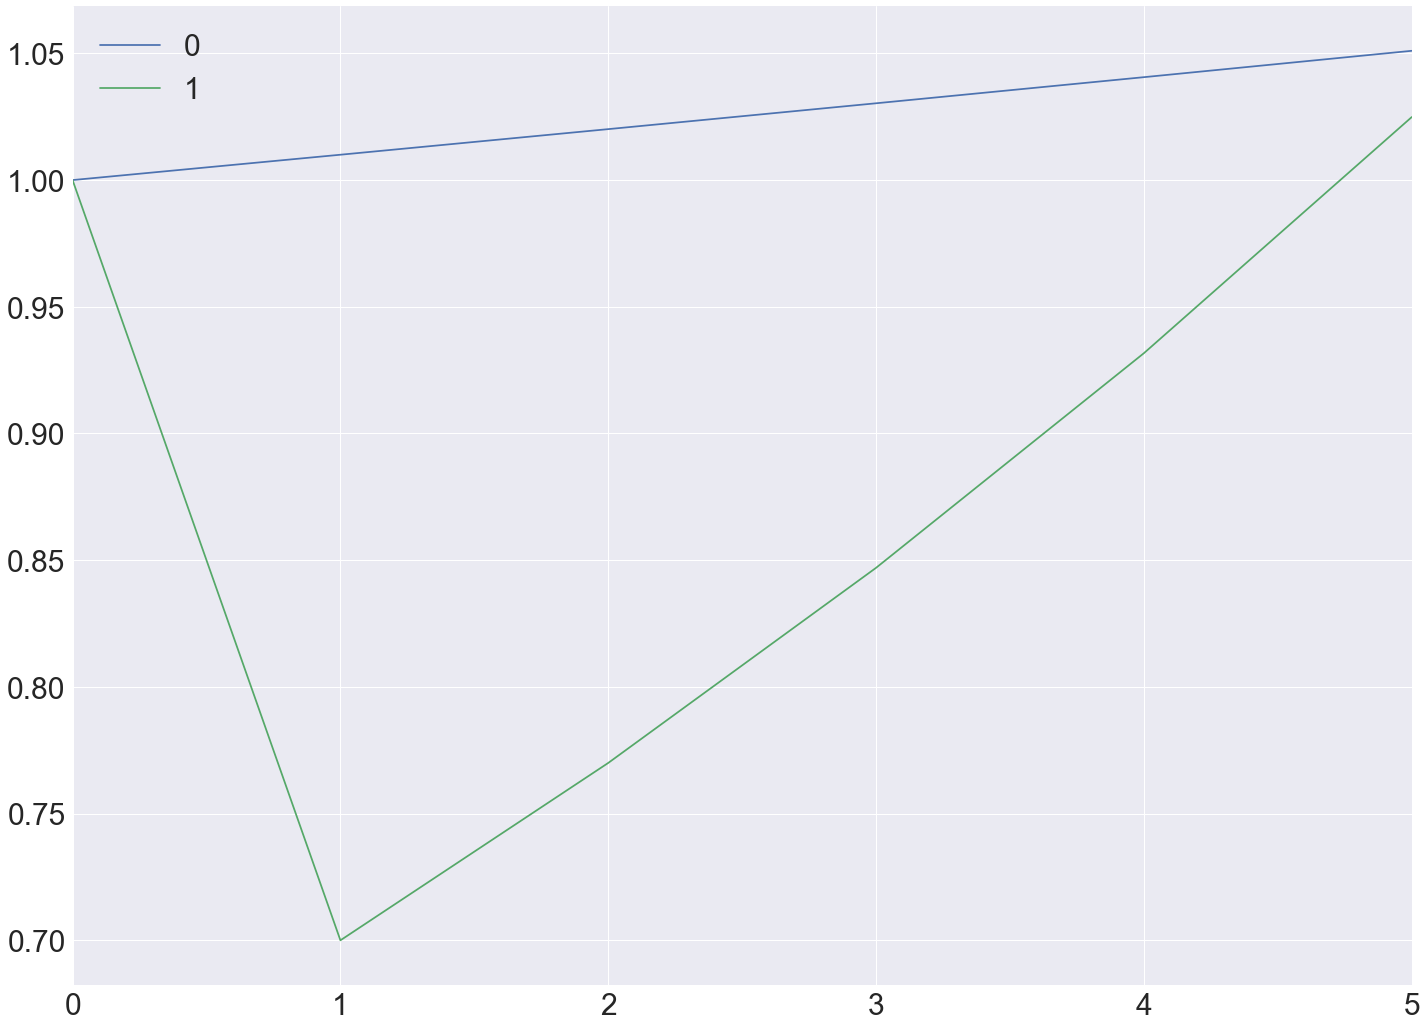

In [58]:
(pd.DataFrame(a)+1).cumprod().plot()